### Lectura de datos

In [153]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import random

random.seed(31415)

D = pd.read_csv("cancer_patient_data_sets.csv")

### Preprocesamiento

Ahora vamos a quitar las columnas index y patient ID que no son necesarias

In [154]:
D=D.drop(columns=["index","Patient Id"])

Tenemos que mirar si los datos estan bien, primero revisamos que no hayan datos nulos en alguna parte

In [155]:
D.isnull().sum()

Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

Tambien revisamos que no esten desbalanceados los datos, esto es, que no haya una gran cantidad de alguna de las clases en comparación a las otras

In [156]:
D['Level'].value_counts()

High      365
Medium    332
Low       303
Name: Level, dtype: int64

Podemos ver que hay un número similar de la cantidad de elementos en las clases, lo que nos indica que los datos son buenos para trabajar con ellos.

Ahora revisamos como es la informacion de cada columna de los datos

In [157]:
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1000 non-null   int64 
 1   Gender                    1000 non-null   int64 
 2   Air Pollution             1000 non-null   int64 
 3   Alcohol use               1000 non-null   int64 
 4   Dust Allergy              1000 non-null   int64 
 5   OccuPational Hazards      1000 non-null   int64 
 6   Genetic Risk              1000 non-null   int64 
 7   chronic Lung Disease      1000 non-null   int64 
 8   Balanced Diet             1000 non-null   int64 
 9   Obesity                   1000 non-null   int64 
 10  Smoking                   1000 non-null   int64 
 11  Passive Smoker            1000 non-null   int64 
 12  Chest Pain                1000 non-null   int64 
 13  Coughing of Blood         1000 non-null   int64 
 14  Fatigue                  

Podemos ver que la columna Level, la cual corresponde a la etiqueta, el tipo de dato es de objeto, luego, haremos una codificación de esta columna para tener numeros enteros, los valores que le daremos son:
 - Low: 0
 - Medium: 1
 - High: 2

In [158]:
D['Level']=D['Level'].replace({'Low':0,'Medium':1,'High':2})
D['Level'].value_counts()

2    365
1    332
0    303
Name: Level, dtype: int64

### Entrenamiento

Para el entrenamiento, probaremos tres modelos distintos, una maquina de vector soporte, un random forest y el ultimo un KNN, y usaremos la libreria Optuna para escoger la mejor configuración de los parametros del modelo.

In [159]:
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

Primero hacemos la division de los datos en train, test, validation, para poder evaluar cual es el mejor modelo y luego probar el mejor obtenido.


In [160]:
X = D.drop(columns=['Level'])
y = D['Level']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 * 0.8 = 0.2

El objetivo para escoger los parametros será minimizar el f1 score, para así tenen una baja cantidad de falsos positivos y falsos negativos ya que ambos son importante evitarlos.

Probaremos primero con la maquina de vector soporte

In [161]:
def objectiveSVM(trial):
    svm_C=trial.suggest_float('svm_C',1e-10,1e5,log=True)
    krn=trial.suggest_categorical('Kernel',['linear','poly','rbf','sigmoid'])

    #entrenamiento
    mvs=svm.SVC(C=svm_C,kernel=krn)
    mvs.fit(X_train,y_train)
 
    #prediccion
    y_pred = mvs.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1


sampler = optuna.samplers.TPESampler(seed=31415)
studySVM = optuna.create_study(sampler=sampler,direction='maximize')
studySVM.optimize(objectiveSVM, n_trials=100)

Mejores Parametros

In [162]:
print(studySVM.best_params)
optuna.visualization.plot_optimization_history(studySVM)

{'svm_C': 225.88869429221327, 'Kernel': 'rbf'}


In [163]:
optuna.visualization.plot_parallel_coordinate(studySVM)

In [164]:
optuna.visualization.plot_param_importances(studySVM)

Validación

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



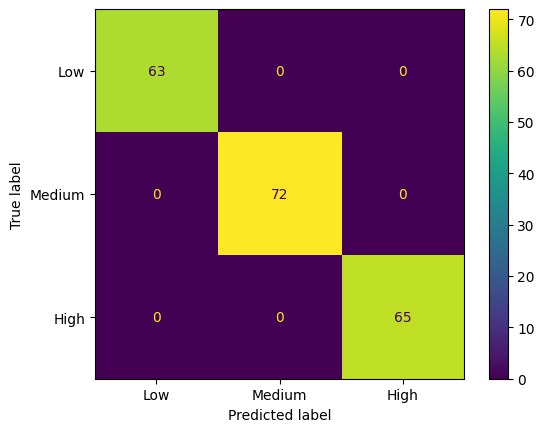

In [165]:
CBest=studySVM.best_params['svm_C']
krn=studySVM.best_params['Kernel']

mvs=svm.SVC(C=CBest,kernel=krn)
mvs.fit(X_train,y_train)

#prediccion
y_pred = mvs.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


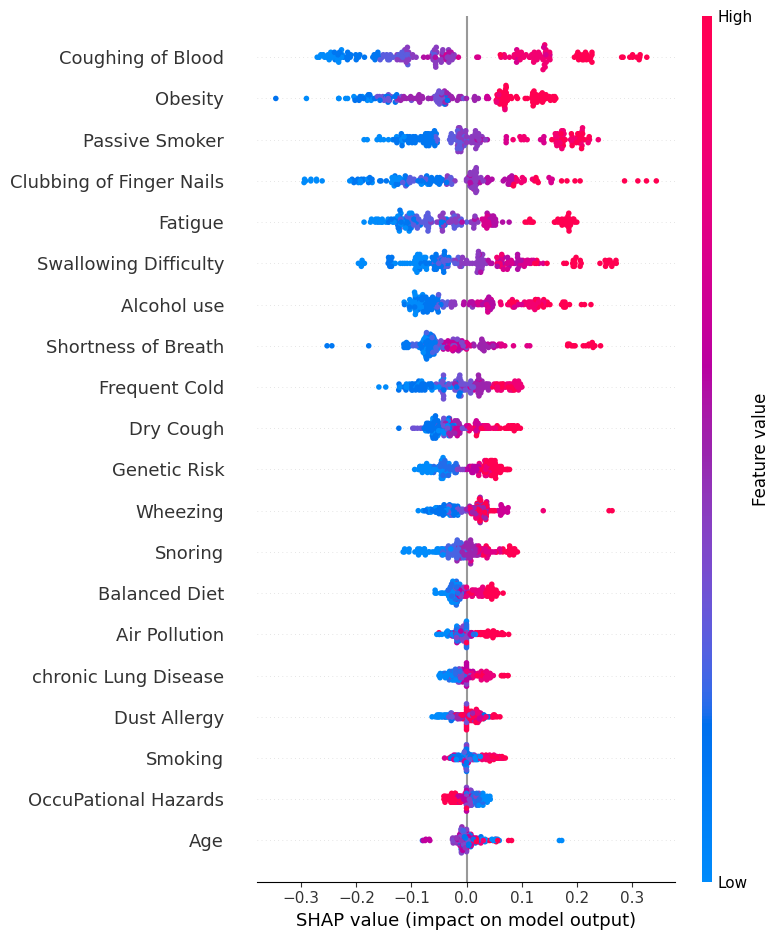

In [166]:
explainer_svm = shap.KernelExplainer(mvs.predict, X_train.sample(20, random_state=1234))
shap_values_svm = explainer_svm(X_test)

shap.summary_plot(shap_values_svm, X_test)

Ahora probamos con un arbol de decisión

In [167]:
def objectiveRF(trial):
    crit=trial.suggest_categorical('Criterion',['gini', 'entropy', 'log_loss'])
    depth=trial.suggest_int('Max_depth',1,15)
    n=trial.suggest_int('estimators',1,150)

    #entrenamiento
    RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
    RF.fit(X_train,y_train)
 
    #prediccion
    y_pred = RF.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1

studyRF = optuna.create_study(sampler=sampler, direction='maximize')
studyRF.optimize(objectiveRF, n_trials=100)

Mejores parametros

In [168]:
print(studyRF.best_params)
optuna.visualization.plot_optimization_history(studyRF)

{'Criterion': 'log_loss', 'Max_depth': 8, 'estimators': 111}


In [169]:
optuna.visualization.plot_parallel_coordinate(studyRF)

In [170]:
optuna.visualization.plot_param_importances(studyRF)

Validación

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



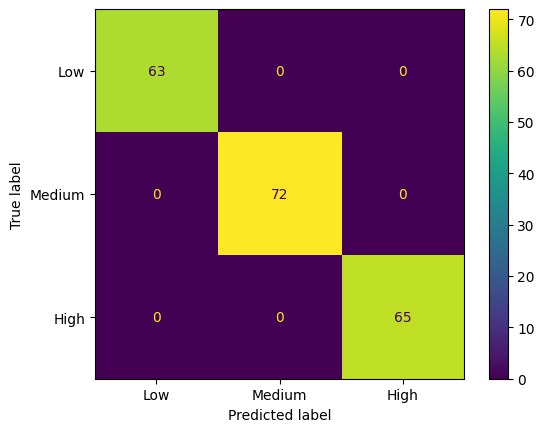

In [171]:
crit=studyRF.best_params['Criterion']
depth=studyRF.best_params['Max_depth']
n=studyRF.best_params['estimators']


RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
RF.fit(X_train,y_train)

#prediccion
y_pred = RF.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

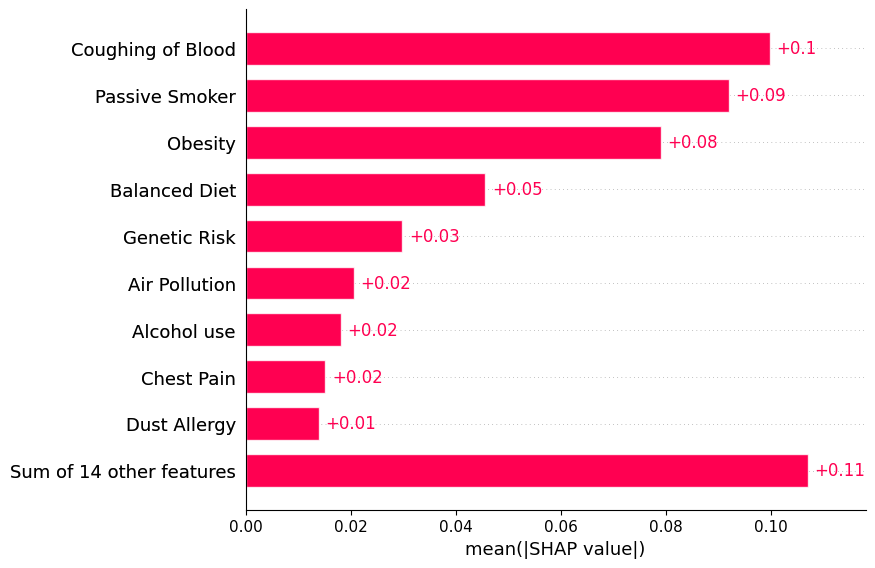

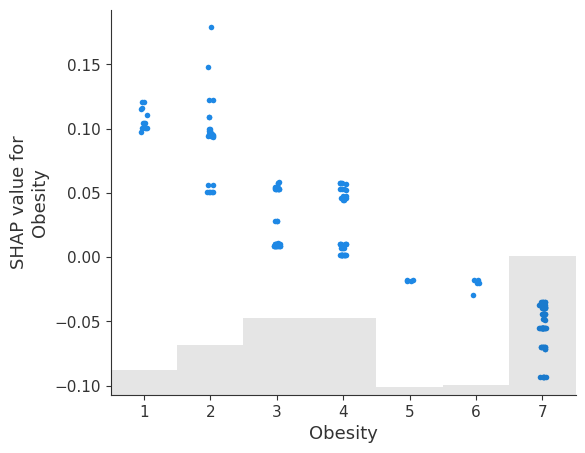

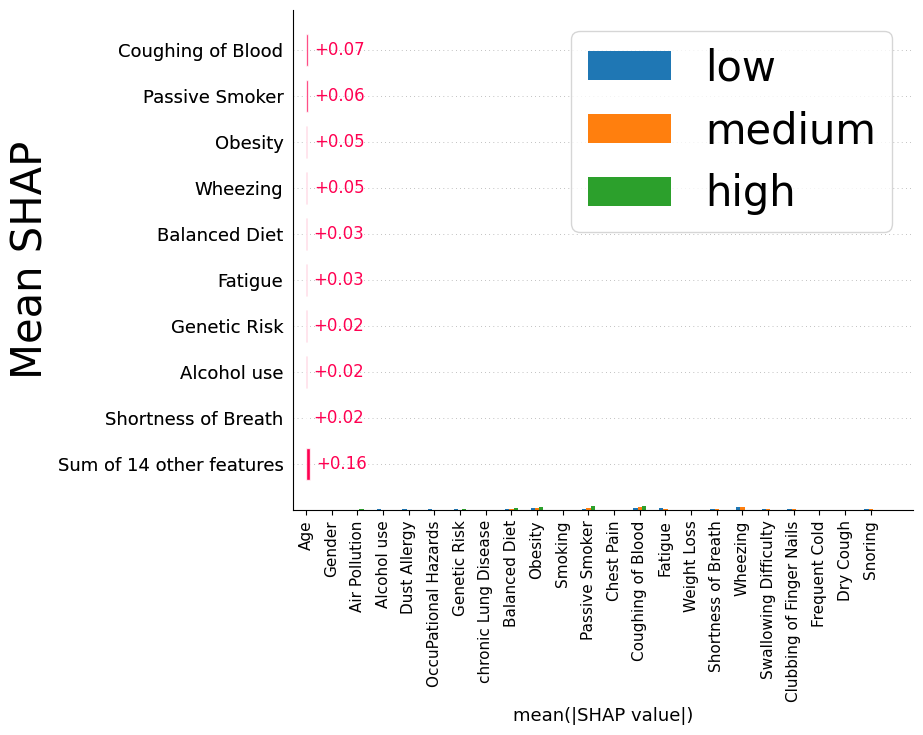

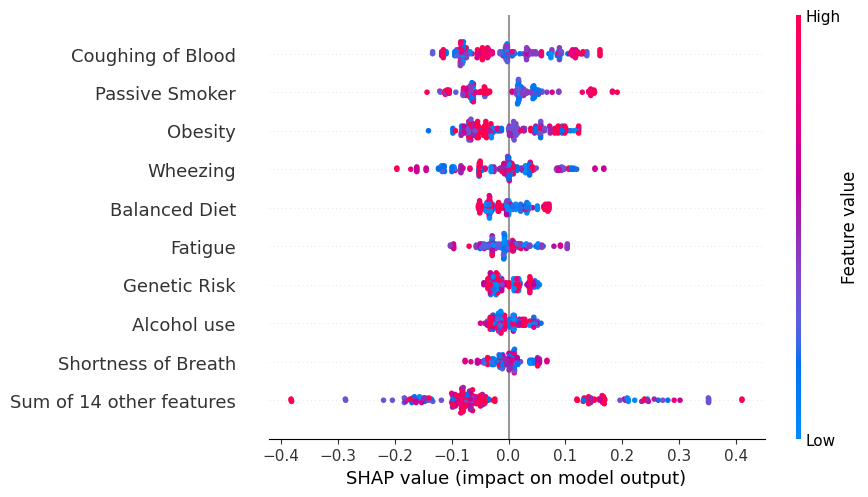

In [172]:
explainer_rfc = shap.Explainer(RF)
shap_values_rfc = explainer_rfc(X_test)
shap.initjs()
shap.plots.bar(shap_values_rfc[:, :, 2])
shap.plots.scatter(shap_values_rfc[:, "Obesity", 0])
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_rfc.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_rfc.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_rfc.values[:,:,2]),axis=0)

df = pd.DataFrame({'low':mean_0,'medium':mean_1,'high':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 30)
ax.set_xticklabels(X.columns,rotation=90,size=15)
ax.legend(fontsize=30)

new_shap_values = []
for i, pred in enumerate(y_pred):
    # get shap values for predicted class
    new_shap_values.append(shap_values_rfc.values[i][:,pred])

shap_values_rfc.values = np.array(new_shap_values)

shap.plots.bar(shap_values_rfc)
shap.plots.beeswarm(shap_values_rfc)

Finalmente, probaremos usando KNN

In [173]:
def objectiveKNN(trial):
    k=trial.suggest_int('K',1,20)

    #entrenamiento
    KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
 
    #prediccion
    y_pred = KNN.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1

studyKNN = optuna.create_study(sampler=sampler, direction='maximize')
studyKNN.optimize(objectiveKNN, n_trials=100)

Mejores parametros

In [174]:
print(studyKNN.best_params)
optuna.visualization.plot_optimization_history(studyKNN)

{'K': 5}


In [175]:
optuna.visualization.plot_parallel_coordinate(studyKNN)

Validación

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



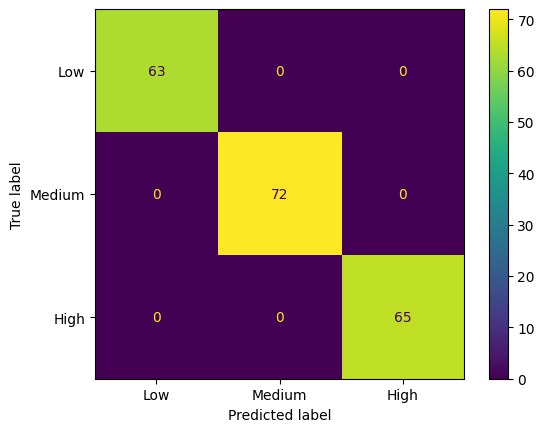

In [176]:
k=studyKNN.best_params['K']


#entrenamiento
KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)

#prediccion
y_pred = KNN.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

100%|██████████| 200/200 [01:26<00:00,  2.31it/s]


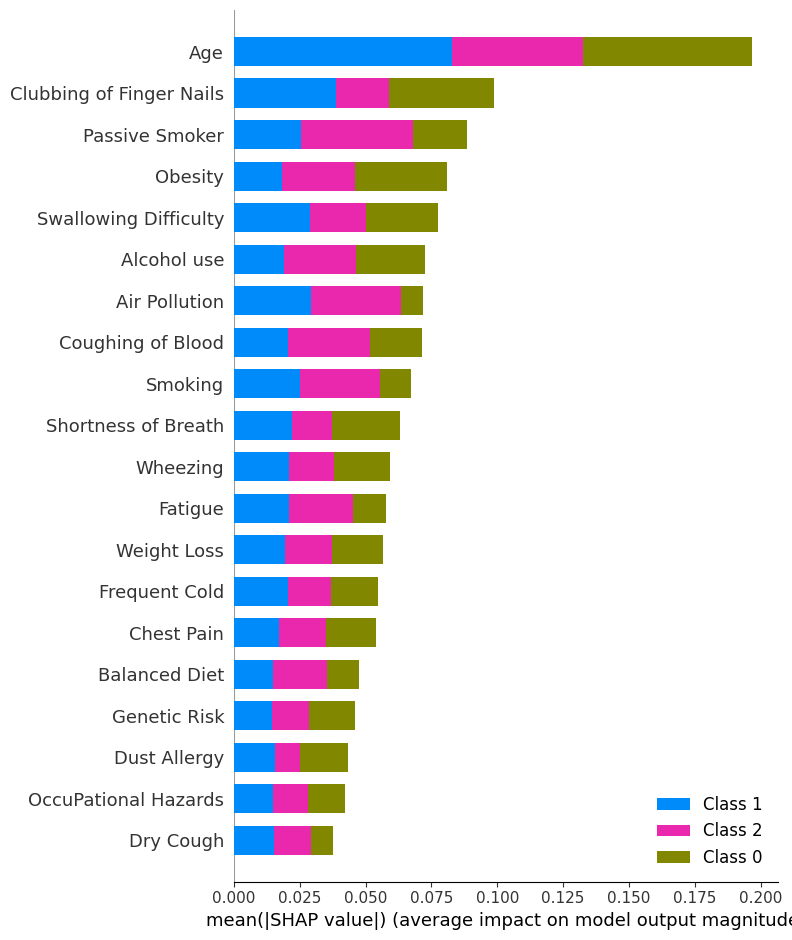

In [177]:
explainer_knn = shap.KernelExplainer(KNN.predict_proba, X_train.sample(15))
shap_values_knn = explainer_knn.shap_values(X_test)
shap.summary_plot(shap_values_knn, X_test)

### Transformación en los datos

Análisis de componentes principales

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA()
pca.fit(X_train)

PCA()

Varianza explicada

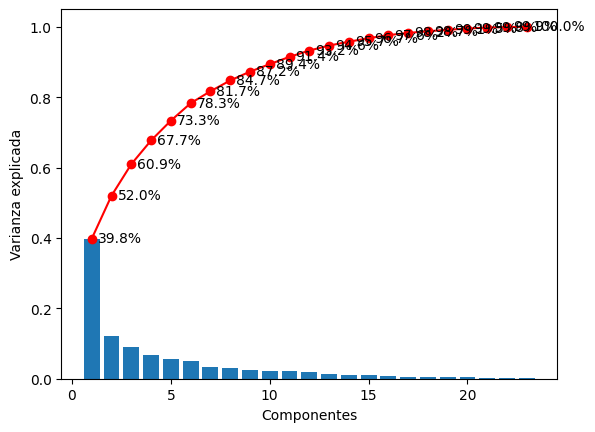

In [179]:
varExp=pca.explained_variance_ratio_
sumVar=varExp.cumsum()
n=[i+1 for i in range(len(sumVar))]
plt.plot(n,sumVar,'r-o')
for a,b in zip(n, sumVar): 
    plt.text(a+0.3, b-0.01, str(round(b*100,1))+"%")
plt.bar(n,varExp)
plt.xlabel("Componentes")
plt.ylabel("Varianza explicada")
plt.show()

In [180]:
pca = PCA(3)
pca.fit(X_train)

X_train = pca.transform(X_train)

X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

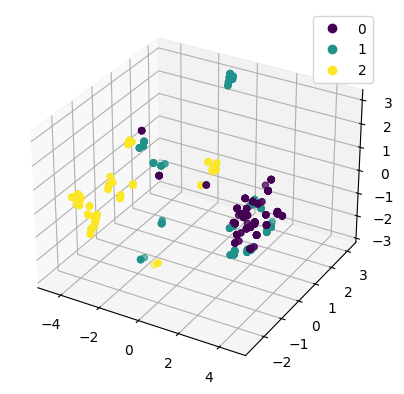

In [181]:
ax=plt.axes(projection='3d')
xdata=X_train[:,0]
ydata=X_train[:,1]
zdata=X_train[:,2]
sc=ax.scatter3D(xdata,ydata,zdata,c=y_train)
ax.legend(*sc.legend_elements())

Entrenamos y validamos la svm

Mejores Parametros:  458.0425536483862 rbf
              precision    recall  f1-score   support

         Low       0.98      1.00      0.99        63
      Medium       1.00      0.99      0.99        72
        High       1.00      1.00      1.00        65

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



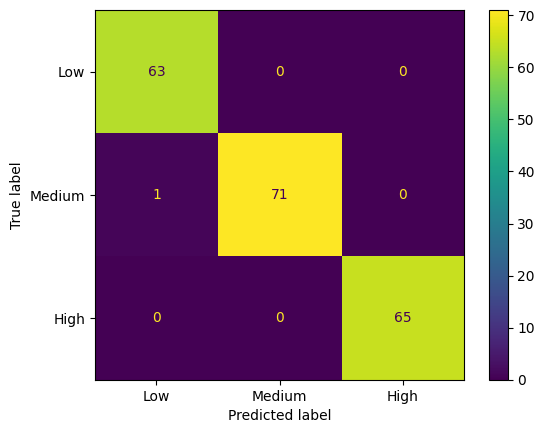

In [182]:
def objectiveSVM(trial):
    svm_C=trial.suggest_float('svm_C',1e-10,1e3,log=True)
    krn=trial.suggest_categorical('Kernel',['linear','poly','rbf','sigmoid'])
    #entrenamiento
    mvs=svm.SVC(C=svm_C,kernel=krn)
    mvs.fit(X_train,y_train)
 
    #prediccion
    y_pred = mvs.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1

studySVM = optuna.create_study(direction='maximize')
studySVM.optimize(objectiveSVM, n_trials=100)

CBest=studySVM.best_params['svm_C']
krn=studySVM.best_params['Kernel']
print("Mejores Parametros: ",CBest,krn)

mvs=svm.SVC(C=CBest,kernel=krn)
mvs.fit(X_train,y_train)

#prediccion
y_pred = mvs.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

Entrenamos y validamos el random forest

Mejores Parametros:  gini 13 80
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



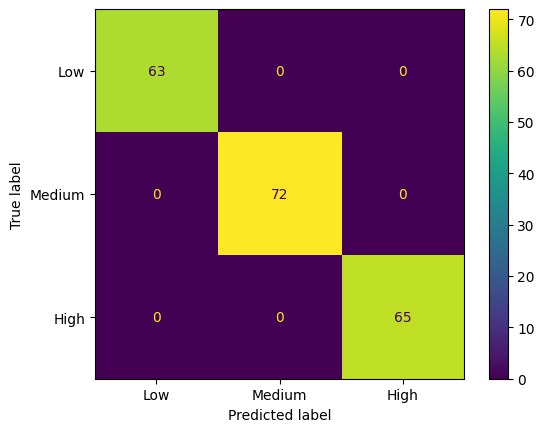

In [183]:
def objectiveRF(trial):
    crit=trial.suggest_categorical('Criterion',['gini', 'entropy', 'log_loss'])
    depth=trial.suggest_int('Max_depth',1,15)
    n=trial.suggest_int('estimators',1,150)

    #entrenamiento
    RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
    RF.fit(X_train,y_train)
 
    #prediccion
    y_pred = RF.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1

studyRF = optuna.create_study(direction='maximize')
studyRF.optimize(objectiveRF, n_trials=100)

crit=studyRF.best_params['Criterion']
depth=studyRF.best_params['Max_depth']
n=studyRF.best_params['estimators']
print("Mejores Parametros: ",crit,depth,n)

RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
RF.fit(X_train,y_train)

#prediccion
y_pred = RF.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

Entrenamos y validamos el KNN

Mejores Parametros:  4
              precision    recall  f1-score   support

         Low       0.98      1.00      0.99        63
      Medium       1.00      0.99      0.99        72
        High       1.00      1.00      1.00        65

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



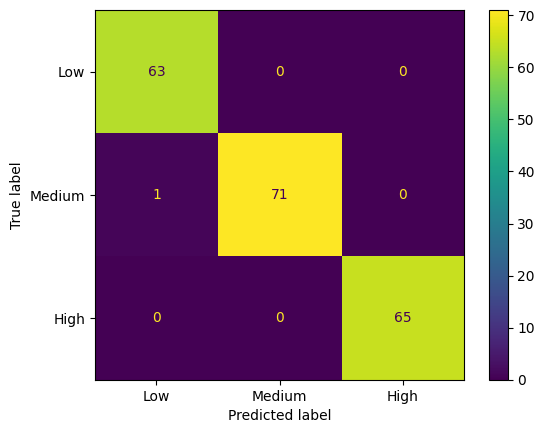

In [184]:
def objectiveKNN(trial):
    k=trial.suggest_int('K',1,20)

    #entrenamiento
    KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
 
    #prediccion
    y_pred = KNN.predict(X_test)

    #metrica
    f1=metrics.f1_score(y_test,y_pred,average='micro')
    return f1

studyKNN = optuna.create_study(direction='maximize')
studyKNN.optimize(objectiveKNN, n_trials=100)

k=studyKNN.best_params['K']
print("Mejores Parametros: ",k)

#entrenamiento
KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)

#prediccion
y_pred = KNN.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()